Note: this notebook has a method of calculating distances between ECTs by using `np.roll` at the beginning, but at the end it has another method by using orientation by PCA. Documentation could be better, this is just to explore.

# Import modules

In [196]:
#-----------------
# Standard imports
#-----------------
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
from sklearn.decomposition import PCA # for PCA for normalization
from scipy.spatial import distance_matrix

from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from sklearn.manifold import MDS # for MDS
import pandas as pd # for loading in colors csv
from scipy.spatial import ConvexHull # for convex hull
import seaborn as sns # for plotting

#---------------------------
# The ECT packages we'll use
#---------------------------
from ect import ECT, EmbeddedGraph # for calculating ECTs

# Define functions

In [197]:
def normalize(shape):
    """
    input: ordered coordinates of a 2D closed contour
    output: 2D array, coordinates origin centered on centroid and longest radius = 1
    """
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(shape) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(shape) # retrieve PCA scores of leaf

    # return leaf normalized by longest axis to 1, zero centered
    return pca_scores/(np.max(pca_scores[:,0])-np.min(pca_scores[:,0]))

In [198]:
def get_ect(normal_sh, dir_num, thresh_num, global_bound_radius):
    """
    inputs: ordered coordinates of a normalized 2D closed contour, longest diameter = 1
    dir_num = number of directional axes
    thresh_num = number of thresholds
    global_bound_radius = half of the longest normalized diameter
    output: ECT as 2D array
    """
    G = EmbeddedGraph() # initiate an embedded graph

    valuesX = normal_sh[:,0] # isolate x vals
    valuesY = normal_sh[:,1] # isolate y vals
    for i in range(np.shape(normal_sh)[0]): # create nodes
        G.add_node(i,valuesX[i],valuesY[i])
    for i in range(np.shape(normal_sh)[0]-1): # create edges
        G.add_edge(i, i+1)
    G.add_edge(0,np.shape(normal_sh)[0]-1) # add final edge between start and end

    myect = ECT(num_dirs = dir_num, num_thresh=thresh_num) # intiate ECT
    myect.set_bounding_radius(global_bound_radius) # set bounding radius
    myect.calculateECT(G) # calculate ECT on embedded graph

    return myect.get_ECT() # retrieve ECT, 2D array, [axes, thresh]

In [199]:
def ect_diff(ect1, ect2,dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    diffs = [] # store differences 
    for i in range(dir_num): # for the number of directional axes
        roll_ect = np.roll(ect1,i,axis=0) # roll the array by 1 along directional axes
        diff_ect = np.abs(ect2 - roll_ect) # difference between the two arrays
        diffs.append(np.sum(diff_ect)) # store the sum of the differences
    return np.min(diffs) # return minimum difference

In [200]:
def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# Define datasets and groups

In [201]:
# a list of folder directories of datasets to analyze
datasets = ["Alstroemeria",
            "Apple",
            "Arabidopsis",
            "Arabidopsis_asymmetry",
            "Brassica/napus",
            "Brassica/rapa",
            "Coleus/Co1",
            "Coleus/Co2",
            "Coleus/Co3",
            "Coleus/Co4",
            "Coleus/Co5",
            "Coleus/Co6",
            "Cotton",
            "Grape/Domesticated_grape/GrapeJune1.2011",
            "Grape/Domesticated_grape/GrapeMay28.2011",
            "Grape/Domesticated_grape/GrapeMay29.2011",
            "Grape/Domesticated_grape/GrapeMay30.2011",
            "Grape/Domesticated_grape/GrapeMay31.2011",
            "Grape/Geneva_2013/Folder1_Jose",
            "Grape/Geneva_2013/Folder2_Tommy",
            "Grape/Geneva_2013/Folder3_Danny",
            "Grape/Geneva_2013/Folder4_Quaneisha",
            "Grape/Geneva_2013/Folder5_Susan",
            "Grape/Geneva_2013/Folder6_Darren",
            "Grape/Geneva_2013/Folder7_Jose2",
            "Grape/Geneva_2013/Folder8_Susan2",
            "Grape/Geneva_2013/Folder9_Tommy2",
            "Grape/Geneva_2013/Folder10_Quaneisha2",
            "Grape/Geneva_2013/Folder11_Darren2",
            "Grape/Geneva_2013/Folder12_Danny",
            "Grape/Geneva_2015/060815",
            "Grape/Geneva_2015/060915",
            "Grape/Geneva_2015/061015",
            "Grape/Geneva_2016/Dan_Geneva_2016",
            "Grape/Geneva_2016/MF_Geneva_2016",
            "Grape/MtVernon_scans/2014_MtVernon_Scans",
            "Grape/MtVernon_scans/2016_MtVernon_Scans",
            "Grass",
            "Ivy",
            "Leafsnap",
            "Passiflora",
            "Pepper",
            "Transect/Batch_1_W",
            "Transect/Batch_2_B",
            "Viburnum/V1",
            "Viburnum/V2",
           ]

# make a list of overall groups
groups = [] # store group names

for i in datasets: # for each dataset
    if "/" in i: # if there are subfolders
        groups.append(i[:i.index('/')]) # then only take the name of the first folder
    elif "_" in i: # if there is a redundant folder with "_" like Arabidopsis
        groups.append(i[:i.index('_')]) # then only take the name of the first folder
    else:
        groups.append(i) # otherwise just take the whole name

# Create a downsampled dataset

Create a pandas dataframe of file names, groups, and datasets

In [202]:
file_names = [] # store file names
dataset = [] # store dataset
group = []

for i in range(len(datasets)): # for each dataset
    
    curr_dataset = datasets[i] # get current dataset
    curr_group = groups[i] # get current group
    data_dir = "./2017_leaves/"+curr_dataset+"/" # set data directory
    files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
    #file_names.remove('.DS_Store') # remove .DS_Store file
    files.sort() # sort the list of file names

    for j in range(len(files)): # for each file
        
        file_names.append("./2017_leaves/"+curr_dataset+"/"+files[j]) # store file names
        dataset.append(curr_dataset) # store datasets
        group.append(curr_group) # store group
        
# create a pandas dataframe of all file info
lf_df = pd.DataFrame(
    {"group":group,
     "dataset":dataset,
     "file":file_names,
    })

# print out number of each dataset
lf_df["group"].value_counts()

group
Coleus          34607
Grape           11379
Apple            9619
Transect         5808
Arabidopsis      5101
Leafsnap         4565
Passiflora       3298
Pepper           3277
Cotton           2885
Viburnum         2422
Alstroemeria     2392
Brassica         1832
Grass             866
Ivy               865
Name: count, dtype: int64

# Select a random number of leaves from each group

In [203]:
rand_num = 100 # select number to randomly sample
df_list = [] # a list to store pandas dataframes

for i in lf_df["group"].unique(): # for each group
    curr_group = lf_df[lf_df["group"]==i] # select all samples of current group
    df_list.append(curr_group.sample(n=rand_num)) # select random rows for the current group
    
rand_df = pd.concat(df_list).reset_index() # concatenate list of dataframes together

print(len(rand_df)) # print the overall length of the selected leaves

1400


# Analyze solidity and aspect ratio

Calculate solidity and aspect ratio

In [204]:
solidity = [] # store solidity values
wl_ratio = [] # store width-to-length ratio values

for i in range(len(rand_df)): # for each of the randomly selected leaves
    
    curr_file = rand_df["file"].iloc[i] # get current file
     
    # calculate solidity
    curr_lf = np.load(curr_file) # load current leaf
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    area = poly_area(curr_lf[:,0], curr_lf[:,1]) # calculate area
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity.append( area / convex_area ) # calculate solidity and store

    # calculate length-to-width ratio
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_lf) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(curr_lf) # retrieve PCA scores of leaf
    length = np.max(pca_scores[:,0])-np.min(pca_scores[:,0]) # get length
    width = np.max(pca_scores[:,1])-np.min(pca_scores[:,1]) # get width
    wl_ratio.append(width/length) # store length-to-width ratio
    
rand_df["solidity8"] = np.array(solidity)**8 # add solidity to random leaves
rand_df["wl_ratio"] = wl_ratio # add width-to-length ratio to random leaves

Plot solidity and aspect ratio

Text(0.5, 1.0, 'Solidity^8 vs width-to-length ratio\nby group')

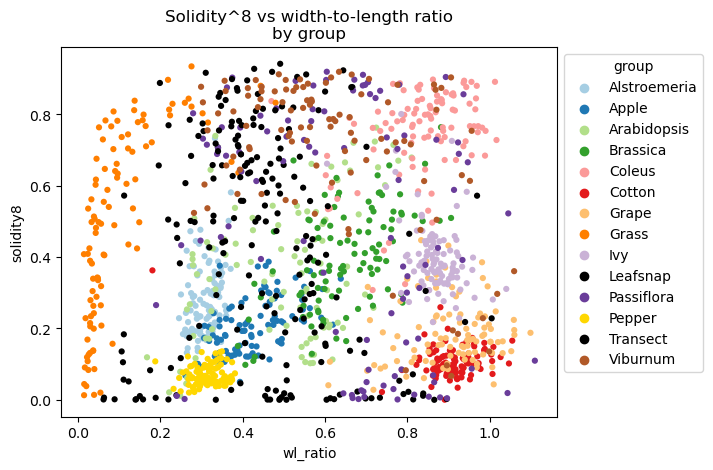

In [207]:
palette = [
"#a6cee3",
"#1f78b4",
"#b2df8a",
"#33a02c",
"#fb9a99",
"#e31a1c",
"#fdbf6f",
"#ff7f00",
"#cab2d6",
"black",
"#6a3d9a",
"gold",
"black",
"#b15928"
]


ax = sns.scatterplot(data=rand_df,
                x="wl_ratio",
                y="solidity8",
                hue="group",
                palette=sns.color_palette(palette, 14),
                s=20,
                linewidth=0,
                alpha=1
               )
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Solidity^8 vs width-to-length ratio\nby group")

Plot solidity ans aspect ratio with leaf outlines

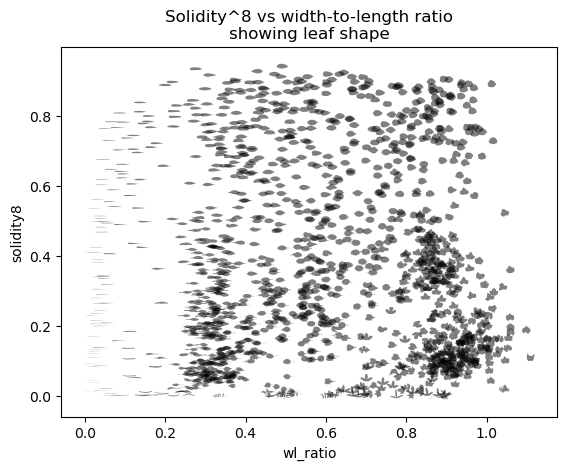

In [237]:
scale = 0.01 # set scale

for i in range(len(rand_df)): # for each of the randomly selected leaves
    
    curr_file = rand_df["file"].iloc[i] # get current file
    curr_lf = np.load(curr_file)
    pca = PCA(n_components=2) # initiate PCA
    pca.fit_transform(curr_lf) # fit PCA to leaf data to find longest axis
    pca_scores = pca.transform(curr_lf) # retrieve PCA scores of leaf
    
    curr_lfx = pca_scores[:,0]*scale+rand_df["wl_ratio"].iloc[i]
    curr_lfy = pca_scores[:,1]*scale+rand_df["solidity8"].iloc[i]
    
    plt.fill(curr_lfx, curr_lfy, lw=0, c="k", alpha=0.5)
    plt.xlabel("wl_ratio")
    plt.ylabel("solidity8")
    plt.title("Solidity^8 vs width-to-length ratio\nshowing leaf shape")
    

# Calculate ECTs for each leaf

In [221]:
num_dir=50 # set number of directional axes
num_thresh=50 # set number of thresholds each axis
rad = 0.5 # set the radius

# create array to store ECT outputs
# number of ECTs x num directional axes x number of thresholds
ect_arr = np.zeros((len(rand_df),num_dir,num_thresh))

for i in range(len(rand_df)): # for each leaf
    if i%100==0: # print if divisible by 100
        print(i)
    shape = np.load(rand_df["file"].iloc[i]) # get the current shape
    ect_arr[i,:,:] = get_ect(normal_sh=normalize(shape), # normalize the shape
           dir_num=num_dir, # calculate the ECT
           thresh_num=num_thresh,
           global_bound_radius=rad)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


# Create distance matrix of ECTs

In [222]:
# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%100==0: # print if divisible by 100
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff(ect1, ect2, dir_num=num_dir) # get difference between ECTs

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


# Perform MDS

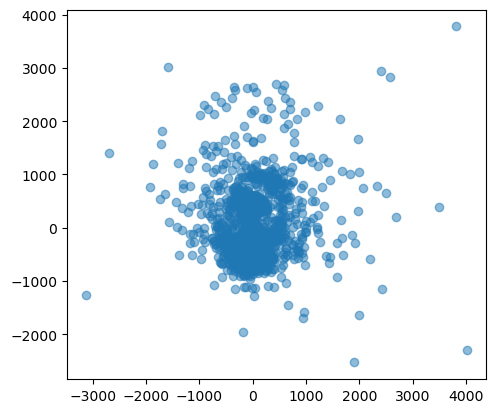

In [223]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
X = dist_arr # select distance array to analyze
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")


# Plot MDS with aspect ratio and solidity

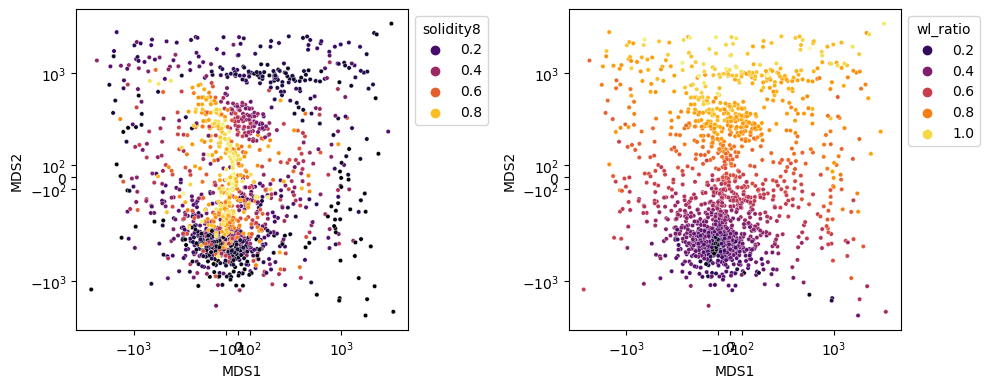

In [268]:
lt = 800

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="solidity8", palette="inferno")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.subplot(1,2,2)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="wl_ratio", palette="inferno")
plt.gca().set_aspect("equal")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.tight_layout()

Text(0.5, 1.0, 'MDS of ECT\nby group')

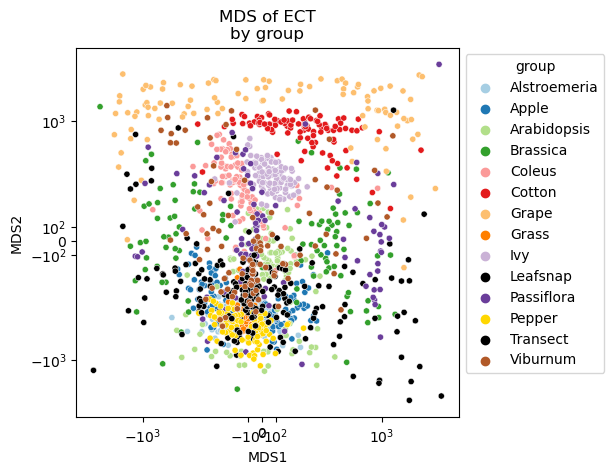

In [269]:
ax = sns.scatterplot(data=rand_df,
                x="MDS1",
                y="MDS2",
                s=20,
                hue="group", 
                palette=sns.color_palette(palette, 14))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("MDS of ECT\nby group")

__________

_______

____________

In [296]:
def ect_diff_pca(ect1, ect2, dir_num):
    """
    inputs: two, 2D arrays of ECTs and number of directional axes
    output: the minimum sum diff between the two ECT arrays across different orientations
    """
    flip_ect1 = np.flip(ect1, axis=0) # flip ECT axes
    trans_ect1 = np.roll(ect1, int(dir_num/2), axis=0) # translate ECT axes
    ft_ect1 = np.roll(flip_ect1, int(dir_num/2), axis=0) # translate ECT axes

    diff_orig = np.sum(np.abs(ect2 - ect1)) # difference between ECT and original
    diff_flip = np.sum(np.abs(ect2 - flip_ect1)) # difference between ECT and flipped
    diff_trans = np.sum(np.abs(ect2 - trans_ect1)) # difference between ECT and translated
    diff_ft = np.sum(np.abs(ect2 - ft_ect1)) # difference between ECT and flipped translated

    return np.min([diff_orig,diff_flip,diff_trans,diff_ft])

In [297]:
# create a 2D array to hold the distance matrix
# number of ECTs x number of ECTs
dist_arr = np.zeros((np.shape(ect_arr)[0],np.shape(ect_arr)[0]))

for i in range(np.shape(ect_arr)[0]): # for each ECT
    if i%100==0: # print if divisible by 100
        print(i)
    ect1 = ect_arr[i] # get first ECT
    for j in range(np.shape(ect_arr)[0]): # for each ECT
        ect2 = ect_arr[j] # get second ECT
        dist_arr[i,j] = ect_diff_pca(ect1, ect2, dir_num=num_dir) # get difference between ECTs

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


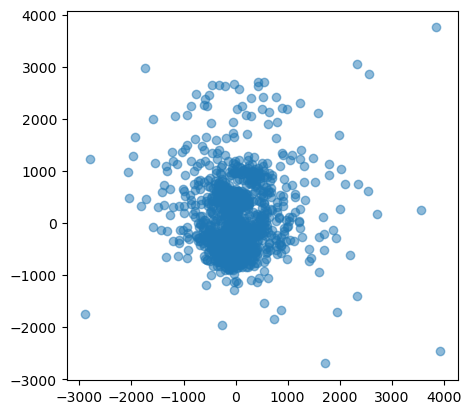

In [298]:
n_components = 2 # select number of components
mds = MDS(n_components=n_components, # initialize MDS
          dissimilarity="precomputed", # we have precomputed the distance matrix
          normalized_stress='auto',
          random_state=5 # select random state for reproducibility
         )
X = dist_arr # select distance array to analyze
MDS_scores = mds.fit_transform(X) # get MDS scores

plt.scatter(MDS_scores[:,0], MDS_scores[:,1], alpha=0.5) # plot
plt.gca().set_aspect("equal")


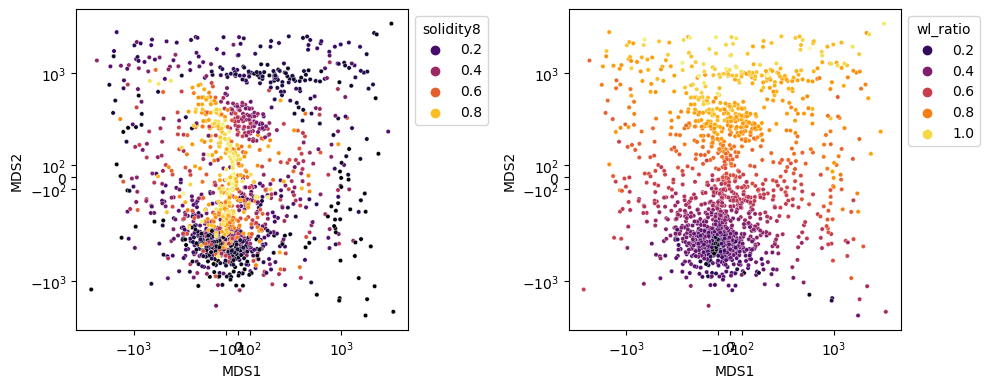

In [299]:
lt = 800

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="solidity8", palette="inferno")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.subplot(1,2,2)
ax=sns.scatterplot(data=rand_df,x="MDS1",y="MDS2",s=10,hue="wl_ratio", palette="inferno")
plt.gca().set_aspect("equal")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)

plt.tight_layout()

Text(0.5, 1.0, 'MDS of ECT\nby group')

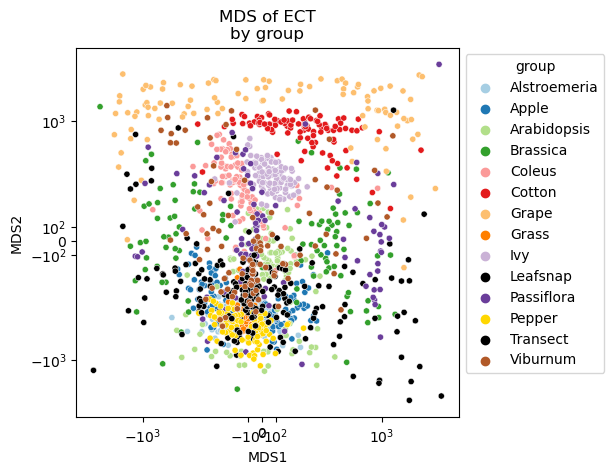

In [300]:
ax = sns.scatterplot(data=rand_df,
                x="MDS1",
                y="MDS2",
                s=20,
                hue="group", 
                palette=sns.color_palette(palette, 14))
plt.gca().set_aspect("equal")
plt.xscale('symlog',linthresh=lt)
plt.yscale('symlog',linthresh=lt)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("MDS of ECT\nby group")